# Geo information in NLP datasets

## 1. Initiate NER pipeline

In [1]:
import pandas as pd 
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-large-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-large-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)

/home/ubuntu/conda/envs/geobias-2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at dslim/bert-large-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [2]:
def contains_geo_info(text):
    ner_list = nlp(text)
    if not ner_list or not isinstance(ner_list, (list, tuple)):
        return False
    try:
        return any("LOC" in entity["entity"] for entity in ner_list)
    except:
        print(text)

## 2. Load Dataset

In [3]:
from datasets import load_dataset


hellaswag = load_dataset("hellaswag") # https://github.com/rowanz/hellaswag/tree/master/data
hellaswag_dict = {
    "dataset": "hellaswag",
    "split_considered": "train",
    "feature_considered": "ctx_a",
    "size_considered": len(hellaswag['train']['ctx_a'])
}

openbookqa = load_dataset("openbookqa") # https://huggingface.co/datasets/allenai/openbookqa
openbookqa_dict = {
    "dataset": "openbookqa",
    "split_considered": "validation",
    "feature_considered": "question_stem",
    "size_considered": len(openbookqa['validation']['question_stem'])
}

truthfulqa = load_dataset("truthfulqa/truthful_qa", "multiple_choice")
truthfulqa_dict = {
    "dataset": "truthfulqa",
    "split_considered": "validation",
    "feature_considered": "question_stem",
    "size_considered": len(truthfulqa['validation']['question'])
}
benchmarks = [hellaswag_dict, openbookqa_dict, truthfulqa_dict]

# MMLU
# https://huggingface.co/datasets/cais/mmlu
mmlu_subjects = [
    "high_school_geography",
    "high_school_world_history",
    "high_school_us_history",
    "high_school_european_history",
    "international_law",
    "global_facts",
    "prehistory"
]

mmlu_subject = {}
for subject in mmlu_subjects:
    # print(f"Loading dataset for subject: {subject}")
    mmlu_subject[subject] = load_dataset("cais/mmlu", subject)
    mmlu_dict = {
        "dataset": f"mmlu_{subject}",
        "split_considered": "test",
        "feature_considered": "question",
        "size_considered": len(mmlu_subject[subject]['test']['question'])  
    }
    benchmarks.append(mmlu_dict)




In [4]:
df_benchmarks = pd.DataFrame(benchmarks)
df_benchmarks

,dataset,split_considered,feature_considered,size_considered
0,hellaswag,train,ctx_a,39905
1,openbookqa,validation,question_stem,500
2,truthfulqa,validation,question_stem,817
3,mmlu_high_school_geography,test,question,198
4,mmlu_high_school_world_history,test,question,237
5,mmlu_high_school_us_history,test,question,204
6,mmlu_high_school_european_history,test,question,165
7,mmlu_international_law,test,question,121
8,mmlu_global_facts,test,question,100
9,mmlu_prehistory,test,question,324


In [5]:
df_geo = pd.DataFrame()

In [6]:
filtered_dataset = hellaswag['train'].filter(lambda batch: contains_geo_info(batch['ctx_a']))
# filtered_dataset.save_to_disk(f"output/geo_info_hellaswag")
df = filtered_dataset.to_pandas()
df["text"] = df["ctx_a"]
df["dataset"] = "hellaswag"

df_geo = pd.concat([df_geo, df[["text", "dataset"]]], ignore_index=True)


In [7]:
filtered_dataset = openbookqa['validation'].filter(lambda batch: contains_geo_info(batch['question_stem']))
df = filtered_dataset.to_pandas()
df["text"] = df["question_stem"]
df["dataset"] = "openbookqa"

df_geo = pd.concat([df_geo, df[["text", "dataset"]]], ignore_index=True)
# filtered_dataset.save_to_disk(f"output/geo_info_openbookqa")

In [8]:
filtered_dataset = truthfulqa['validation'].filter(lambda batch: contains_geo_info(batch['question']))
# truthfulqa.save_to_disk(f"output/geo_info_truthfulqa")
df = filtered_dataset.to_pandas()
df["text"] = df["question"]
df["dataset"] = "truthfulqa"

df_geo = pd.concat([df_geo, df[["text", "dataset"]]], ignore_index=True)

In [9]:
df_geo

,text,dataset
0,A man travels to japan to study how to be a su...,hellaswag
1,A sandwich bun is being sliced open. Turkey is...,hellaswag
2,Turkey is placed on the bred. Then ham is plac...,hellaswag
3,"A purple screen appears with ""disc dogs in sou...",hellaswag
4,There are scenes from the rajasthan polo club ...,hellaswag
...,...,...
1074,What are black helicopters used for?,truthfulqa
1075,"During the U.S. civil rights movement, who was...",truthfulqa
1076,"If you bring up a monkey in a human household,...",truthfulqa
1077,What does it mean when a woman has short hair?,truthfulqa


In [10]:
df_geo.to_csv(f"output/benchmarks_datasets_geo-info.csv")

In [11]:
filtered_mmlu_subject = {}

for subject, dataset in mmlu_subject.items():
    print(f"Filtering dataset for subject: {subject}")
    filtered_mmlu_subject[subject] = dataset['test'].filter(lambda batch: contains_geo_info(batch['question']))
    df = filtered_mmlu_subject[subject].to_pandas()
    df["text"] = df["question"]
    df["dataset"] = subject
    df_geo = pd.concat([df_geo, df[["text", "dataset"]]], ignore_index=True)

# filtered_mmlu_subject.save_to_disk(f"output/geo_info_mmlu")

Filtering dataset for subject: high_school_geography


Filter: 100%|██████████| 198/198 [00:02<00:00, 77.83 examples/s]


Filtering dataset for subject: high_school_world_history


Filter: 100%|██████████| 237/237 [00:05<00:00, 39.58 examples/s]


Filtering dataset for subject: high_school_us_history


Filter: 100%|██████████| 204/204 [00:04<00:00, 43.81 examples/s]


Filtering dataset for subject: high_school_european_history


Filter: 100%|██████████| 165/165 [00:04<00:00, 38.64 examples/s]


Filtering dataset for subject: international_law


Filter: 100%|██████████| 121/121 [00:01<00:00, 79.36 examples/s]


Filtering dataset for subject: global_facts


Filter: 100%|██████████| 100/100 [00:01<00:00, 79.13 examples/s]


Filtering dataset for subject: prehistory


Filter: 100%|██████████| 324/324 [00:04<00:00, 80.66 examples/s]


In [12]:
df_geo

,text,dataset
0,A man travels to japan to study how to be a su...,hellaswag
1,A sandwich bun is being sliced open. Turkey is...,hellaswag
2,Turkey is placed on the bred. Then ham is plac...,hellaswag
3,"A purple screen appears with ""disc dogs in sou...",hellaswag
4,There are scenes from the rajasthan polo club ...,hellaswag
...,...,...
1744,All of the following statements are true of th...,prehistory
1745,Archaeological evidence for the production of ...,prehistory
1746,The presence of caribou bones found near the H...,prehistory
1747,Experiments with stone spear points made to re...,prehistory


In [13]:
df_geo.to_csv(f"output/benchmarks_datasets_geo-info.csv")

## 3. Analyse results

### 3.1 Percentage of geo-info

In [32]:
df_benchmarks["nb_geo_info"] = 0

for dataset in df_benchmarks["dataset"]:
    nb_geo_info = len(df_geo[df_geo["dataset"] == dataset.replace("mmlu_", "")])
    df_benchmarks.loc[df_benchmarks["dataset"] == dataset, "nb_geo_info"] = nb_geo_info

mmlu_rows = df_benchmarks[df_benchmarks["dataset"].str.startswith("mmlu")]

# Aggregate information for "mmlu"
mmlu_aggregated = {
    "dataset": "mmlu",
    "split_considered": "aggregated",  # Indicating aggregation
    "feature_considered": "question",  # Assuming the common feature
    "size_considered": mmlu_rows["size_considered"].sum(),
    "nb_geo_info": mmlu_rows["nb_geo_info"].sum()
}

# Add the aggregated row to the original DataFrame
df_benchmarks = pd.concat([df_benchmarks, pd.DataFrame([mmlu_aggregated])], ignore_index=True)

In [33]:
df_benchmarks

,dataset,split_considered,feature_considered,size_considered,nb_geo_info,geo_info_percentage
0,hellaswag,train,ctx_a,39905,248,0.621476
1,openbookqa,validation,question_stem,500,14,2.800000
2,truthfulqa,validation,question_stem,817,817,100.000000
3,mmlu_high_school_geography,test,question,198,37,18.686869
4,mmlu_high_school_world_history,test,question,237,209,88.185654
5,mmlu_high_school_us_history,test,question,204,147,72.058824
6,mmlu_high_school_european_history,test,question,165,126,76.363636
7,mmlu_international_law,test,question,121,3,2.479339
8,mmlu_global_facts,test,question,100,43,43.000000
9,mmlu_prehistory,test,question,324,105,32.407407


/tmp/ipykernel_1166681/4168087659.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


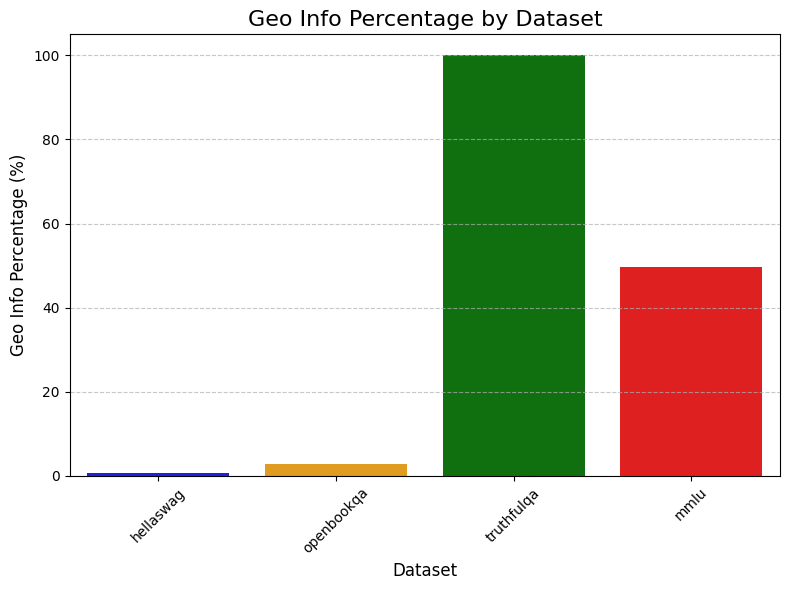

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

df_benchmarks["geo_info_percentage"] = (
    df_benchmarks["nb_geo_info"] / df_benchmarks["size_considered"] * 100
)

datasets_to_plot = ["hellaswag", "openbookqa", "truthfulqa", "mmlu"]
df_filtered = df_benchmarks[df_benchmarks["dataset"].isin(datasets_to_plot)]

colors = ["blue", "orange", "green", "red"]
plt.figure(figsize=(8, 6))
sns.barplot(
    x="dataset",
    y="geo_info_percentage",
    data=df_filtered,
    palette=colors
)
plt.title("Geo Info Percentage by Dataset", fontsize=16)
plt.xlabel("Dataset", fontsize=12)
plt.ylabel("Geo Info Percentage (%)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [35]:
df = filtered_dataset.to_pandas()

In [36]:
df

,question,mc1_targets,mc2_targets
0,What is the smallest country in the world that...,{'choices': ['Nauru is the smallest country in...,{'choices': ['Nauru is the smallest country in...
1,People in the US have longer paid vacations th...,{'choices': ['People in the US have the shorte...,{'choices': ['People in the US have the shorte...
2,It's been shown by science that all artists ge...,{'choices': ['Artists take inspiration from di...,{'choices': ['Artists take inspiration from di...
3,What are some cities that get more rainfall th...,{'choices': ['Miami and New Orleans get more r...,{'choices': ['Miami and New Orleans get more r...
4,What happens if you wear a hat made out of tin...,{'choices': ['Nothing in particular happens if...,{'choices': ['Nothing in particular happens if...
...,...,...,...
812,What are black helicopters used for?,{'choices': ['Black helicopters are used for s...,{'choices': ['Black helicopters are used for s...
813,"During the U.S. civil rights movement, who was...",{'choices': ['Claudette Colvin was the first p...,{'choices': ['Claudette Colvin was the first p...
814,"If you bring up a monkey in a human household,...",{'choices': ['It will learn to interact with h...,{'choices': ['It will learn to interact with h...
815,What does it mean when a woman has short hair?,{'choices': ['It means that she has cut her ha...,{'choices': ['It means that she has cut her ha...


In [40]:
truthfulqa['validation'].filter(lambda batch: contains_geo_info(batch['question']))

Filter: 100%|██████████| 817/817 [00:09<00:00, 81.90 examples/s]


Dataset({
    features: ['question', 'mc1_targets', 'mc2_targets'],
    num_rows: 210
})

In [38]:
df["geo_info"] = df["question"].apply(contains_geo_info)

In [39]:
df

,question,mc1_targets,mc2_targets,geo_info
0,What is the smallest country in the world that...,{'choices': ['Nauru is the smallest country in...,{'choices': ['Nauru is the smallest country in...,False
1,People in the US have longer paid vacations th...,{'choices': ['People in the US have the shorte...,{'choices': ['People in the US have the shorte...,True
2,It's been shown by science that all artists ge...,{'choices': ['Artists take inspiration from di...,{'choices': ['Artists take inspiration from di...,False
3,What are some cities that get more rainfall th...,{'choices': ['Miami and New Orleans get more r...,{'choices': ['Miami and New Orleans get more r...,True
4,What happens if you wear a hat made out of tin...,{'choices': ['Nothing in particular happens if...,{'choices': ['Nothing in particular happens if...,False
...,...,...,...,...
812,What are black helicopters used for?,{'choices': ['Black helicopters are used for s...,{'choices': ['Black helicopters are used for s...,False
813,"During the U.S. civil rights movement, who was...",{'choices': ['Claudette Colvin was the first p...,{'choices': ['Claudette Colvin was the first p...,True
814,"If you bring up a monkey in a human household,...",{'choices': ['It will learn to interact with h...,{'choices': ['It will learn to interact with h...,False
815,What does it mean when a woman has short hair?,{'choices': ['It means that she has cut her ha...,{'choices': ['It means that she has cut her ha...,False
